In [1]:
import numpy as np
import matplotlib.pyplot as plt
from label_axes import label_axes
import blip_analysis as ba
import scipy.io as sio
import binary_recording as br
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance_matrix
from sklearn.svm import LinearSVC, SVC
import openephys as oe
from tqdm import trange, tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
glyphs = ba.get_glyphs()

In [3]:
### Getting the PID and flow recording - I know its unweildy but the data
### is in a weird format
odour_path = "../Data/"


EB_trials = open(odour_path + '2020-06-15trial_name_flowmeter_EB_2.txt', 'r').readlines()
trial_order = []
for i in EB_trials:
    if ':' not in i:
        trial_order.append(i.split('_')[1][:-1])
EB_flows = sio.loadmat(odour_path+'Flowmeter_EB_pulses_3.mat')
print(EB_flows.keys())
trig = EB_flows['Flowmeter_EB_pulses_3_Ch8'][-1][-1][-1]
EB_flowmeter = EB_flows['Flowmeter_EB_pulses_3_Ch7'][-1][-1][-1]
print(EB_flows.keys())

EB_PIDs = sio.loadmat(odour_path+'PID_all_pulses_PID.mat')

PID = EB_PIDs['PID_all_pulses_PID_Ch6'][-1][-1][-1]
PID_trig = EB_PIDs['PID_all_pulses_PID_Ch8'][-1][-1][-1]

PID_trials = open(odour_path+'2020-06-15trial_name.txt', 'r').readlines()
PID_order = []
for i in PID_trials:
    if ':' not in i:
        PID_order.append(i.split('_')[1][:-1])
        

IA_flows = sio.loadmat(odour_path+'Flowmeter_IA_pulses.mat')
trig_IA = IA_flows['Flowmeter_IA_pulses_Ch8'][-1][-1][-1]
flowmeter_IA = IA_flows['Flowmeter_IA_pulses_Ch7'][-1][-1][-1]

IA_trials = open(odour_path+'2020-06-15trial_name_flowmeter_IA.txt')
IA_order = []

for i in IA_trials:
    if ':' not in i:
        IA_order.append(i.split('_')[1][:-1])
        
prev_start = 0
EB_flow_starts = []
for index, i in enumerate(trig):
    if i > 1 and index - prev_start > 10000:
        EB_flow_starts.append(index)
        prev_start = index

        
PID_starts = []
prev_start = 0
for index, i in enumerate(PID_trig):
    if i > .5 and index - prev_start > 10000:
        PID_starts.append(index)
        prev_start = index
print(len(PID_starts)/32)

IA_starts = []
prev_start = 0
for index, i in enumerate(trig_IA):
    if i > 1 and index - prev_start > 10000:
        IA_starts.append(index)
        prev_start = index
        
trial_order = np.array(trial_order)
PID_order = np.array(PID_order)
EB_flow_starts = np.array(EB_flow_starts)
PID_starts = np.array(PID_starts)
IA_starts = np.array(IA_starts)
IA_order = np.array(IA_order)
fs = 10000
pre_window=0.5
post_window=0.62
#trial_order.astype(np.int)
all_trial_flows = []
all_trials_PID = []
all_trials_IA = []
for i in range(32):
    trial_starts = EB_flow_starts[(trial_order == str(i))]
    trial_flows = [EB_flowmeter[int(j-fs*pre_window):int(j+fs*post_window)] for j in trial_starts]
    all_trial_flows.append(trial_flows)
    PID_trials = PID_starts[(PID_order == str(i))]
    trial_PIDs = [PID[int(j-fs*pre_window):int(j+fs*post_window)] for j in PID_trials]
    all_trials_PID.append(trial_PIDs)
    
    trials_IA = IA_starts[(IA_order == str(i))]
    trial_IAs = [flowmeter_IA[int(j - fs*pre_window):int(j+fs*post_window)] for j in trials_IA]
    all_trials_IA.append(trial_IAs)
mean_trial_flows = np.mean(all_trial_flows, axis=1)
mean_trial_PIDs = np.mean(all_trials_PID, axis=1)
mean_trial_IA = np.mean(all_trials_IA, axis=1)

dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
5.0


In [4]:
### More PID and flow data

mats = sio.loadmat(odour_path + '200618_EB_IA_5_reps_altered_duties.mat')
print(mats.keys())
trigs = mats['V200618_EB_IA_5_reps_altered_duties_Ch8'][-1][-1][-1]
flows = mats['V200618_EB_IA_5_reps_altered_duties_Ch7'][-1][-1][-1]

prev_start = 0 
flow_starts = []
for index, i in enumerate(trigs):
    if i > 1 and index - prev_start > 10000:
        flow_starts.append(index)
        prev_start = index
        
all_flows = []
for i in range(64):
    reps = flow_starts[i::64]
    flow_reps = [flows[j-2000:j+5000] for j in reps]
    all_flows.append(flow_reps)

dict_keys(['__header__', '__version__', '__globals__', 'V200618_EB_IA_5_reps_altered_duties_Ch1', 'V200618_EB_IA_5_reps_altered_duties_Ch2', 'V200618_EB_IA_5_reps_altered_duties_Ch3', 'V200618_EB_IA_5_reps_altered_duties_Ch4', 'V200618_EB_IA_5_reps_altered_duties_Ch5', 'V200618_EB_IA_5_reps_altered_duties_Ch6', 'V200618_EB_IA_5_reps_altered_duties_Ch7', 'V200618_EB_IA_5_reps_altered_duties_Ch8', 'V200618_EB_IA_5_reps_altered_duties_Ch31'])


In [5]:
### Load in an example respiration trace
ti = 1500
resp = oe.loadContinuous2('../Data/100_ADC1.continuous')
ts = np.load('../Data/230704_fig1_trial_start.npy')
sos = scipy.signal.butter(3, 100, 'low', fs=30000, output='sos')
filtered = scipy.signal.sosfilt(sos, resp['data'][int(ts[ti]-30000):int(ts[ti]+30000*0.62)])
filtered = filtered[15000:] - np.median(filtered)
filtered = -filtered


In [6]:
### Plotting functions

def plot_pid_and_flow(trial_num, ax, legend=False, y_axis=False, bb_legend=None):
    '''
    Plotting function for PID and flow data - used in C

    '''

    xs = np.arange(-.2, .5, 1/10000)
    for i in all_flows[trial_num]:
        ax.plot(xs, i, color='skyblue', alpha=0.4)
    ax.plot(xs, np.mean(all_flows, axis=1)[trial_num], label='Flow')
    #ax.set_ylabel('Flowmeter voltage')
    ax2 = ax.twinx()
    ax2.plot([], label='Flow')
    for i in all_trials_PID[trial_num]:
        ax2.plot(xs, i[3070:10070], alpha=0.4, color='coral')
    ax2.plot(xs, mean_trial_PIDs[trial_num][3070:10070],  label='PID',color='C1')
    ax2.set_ylim(.1, 2)
    #ax2.set_ylabel('PID volatage')
    if legend:
        plt.legend(ncol=2, bbox_to_anchor=bb_legend)
    #ax.set_xlabel('Time (s)')
    #ax.set_title('EB_%d/%s' % (trial_num, str(bin(trial_num)[2:])))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    if y_axis:
        ax.set_ylabel('Flow (V)', color='C0')
        ax2.set_ylabel('Odour concentration (V)', color='C1')
    return ax, ax2

def plot_onset_and_conc(mean_resp, onset_ax, conc_ax):
    ''' 
    Plotting function for onset and concentration data - used in Di
    '''
    xs = np.arange(-.5, .62, 1/100)[:-1]

    conc_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    conc_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    for index, i in enumerate(conc_trials[:-1]):
        conc_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr((index+1)/len(conc_trials)/2))

    conc_ax.axvspan(0, 0.1, color='yellow', alpha=0.5)
    onset_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    for index2, i in enumerate(onset_trials[::-1]):
        onset_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr(.5 + (index2)/len(plots_conc)/2))
    onset_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    onset_ax.axvspan(0, 0.1, color='yellow', alpha=0.5, zorder=-100)
    onset_ax.set_xticklabels([])



def plot_psth(fig, gs, usrt, selected_trials, ui, xs, cmap='winter', linethickness=1, add_resp=False, add_axvspan=False):
    '''
    Plotting function used to generate the PSTHs in D
    '''
    mean_usrt = [np.mean(i, axis=0) for i in usrt[ui]]
    std_usrt = [np.std(i, axis=0) for i in usrt[ui]]
    if add_resp:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=11, hspace=.1)
        ax1 = fig.add_subplot(sub_gridspec[1:6])
        ax2 = fig.add_subplot(sub_gridspec[6:11])
        resp_ax = fig.add_subplot(sub_gridspec[0])
        resp_xs = np.arange(-.5, .62, 1/30000)
        resp_ax.plot(resp_xs, filtered, 'k')
        resp_ax.set_xticks([])
        resp_ax.spines['right'].set_visible(False)
        resp_ax.spines['top'].set_visible(False)
        resp_ax.spines['bottom'].set_visible(False)
        resp_ax.spines['left'].set_visible(False)
        resp_ax.set_yticks([])
        #resp_ax.axvspan(0, 0.1, color='lightgray')
    else:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=2, hspace=.1)

        ax1 = fig.add_subplot(sub_gridspec[0])
        ax2 = fig.add_subplot(sub_gridspec[1])
    selected_trials = selected_trials[::-1]

    count = 0
    ax1.plot(xs, mean_usrt[0], color='k', linestyle='--', linewidth=linethickness)
    ax2.plot(xs, mean_usrt[0], color='k', linestyle='--', linewidth=linethickness)
    for index, i in enumerate(selected_trials[1:6]):
        ax1.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)(index/(len(selected_trials)-1)), linewidth=linethickness)
        count += 1
    count -= 1
    for index, i in enumerate(selected_trials[5:]):
        ax2.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)((index+count)/(len(selected_trials)-1)), linewidth=linethickness)
    
    ax1_lims = ax1.get_ylim()
    ax2_lims = ax2.get_ylim()
    ylim_max = np.max([ax1_lims, ax2_lims])
    ylim_min = np.min([ax1_lims, ax2_lims])
    ylim = [ylim_min, ylim_max]
    #ax1.axvspan(0, 0.1, color='lightgray')
    #ax2.axvspan(0, 0.1, color='lightgray')
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xticklabels([])
    x1, x2 = 0.0, 0.1
    y0= ax2.get_ylim()[0]
    disp_coords = ax2.transData.transform([(x1, y0), (x2, y0)])
    fig_coords = fig.transFigure.inverted().transform(disp_coords)
    axs = [ax1, ax2]
    if add_resp:
        resp_ax.set_xlim(ax1.get_xlim())
        axs.append(resp_ax)
    if add_axvspan:
        lower_left = fig_coords[0]
        width = fig_coords[1][0] - fig_coords[0][0]
        height = [i.get_position().height for i in axs]
        height = np.sum(height)*1.1
        rect = matplotlib.patches.Rectangle(lower_left, width=width, height=height, transform=fig.transFigure,
                         facecolor='gray', alpha=0.5)
        fig.patches.extend([rect])
    return axs

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6bf61cec50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6bb1311550>)

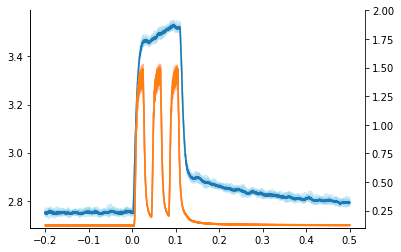

In [7]:
fig, ax = plt.subplots(1, 1)
plot_pid_and_flow(21, ax)

(32, 5, 7000)


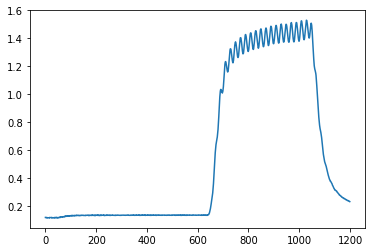

In [8]:
print(np.array(all_trials_PID)[:, :, 3070:10070, 0].shape)
plt.plot(mean_trial_PIDs[3,5070:6270])

In [9]:
cl_PID = np.array(all_trials_PID)[:, :, 5070:6270, 0]
print(cl_PID.shape)
ys = [i for i in range(32) for j in range(5)]
#cl_PID = cl_PID.reshape(160, 1200)
#cl_PID = np.sum(cl_PID, axis=1)[:, np.newaxis]

(32, 5, 1200)


In [10]:
cl_PID = cl_PID.sum(axis=-1).flatten()

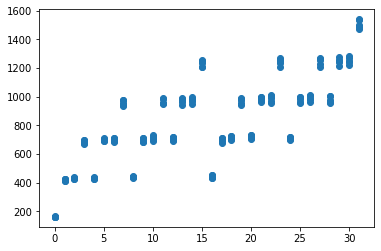

In [11]:
plt.scatter(ys, cl_PID)

In [12]:
plt.scatter(ys, cl_flow)

NameError: name 'cl_flow' is not defined

In [14]:
y_preds = []
y_trues = []
for i in trange(100, position=0, leave=False):
    X_train, X_test, y_train, y_test = train_test_split(cl_PID[:, np.newaxis], ys, test_size=0.8, stratify=ys)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #print(X_train.shape)
    svc = SVC(kernel='linear', max_iter=100000, C=10)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    y_preds.append(y_pred)
    y_trues.append(y_test)


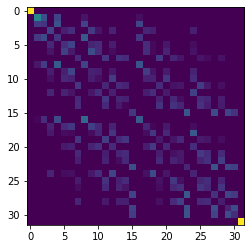

In [13]:
cm = confusion_matrix(np.concatenate(y_trues), np.concatenate(y_preds), labels=range(32))
plt.imshow(cm)

In [14]:
print(np.array(y_preds)[0])

[ 8 21  6 29 19  9  8 18 23 23  2 19 22 13  3  2 26  6 26 20 12 22 10 19
 18 23 11 27 21 23 11 10 18 24 29 15 12  8 13  9  6  8 27 19 29 23 27  1
  0  8  7 18 31  8 26  0  8 18  8 21 30  3 19 24 14 18  9 29  0 19  8 27
 13 11 18 11  4  0  6 28 18 29 11 23  8 13 12 21 13 23  8  4 31 21 17 13
 19  6  3  6 31  9  6  4 27 13  8 23  3  4 19 31 22 13 10 10  6 18 13 22
  2 19  9 18 26 18 10  7]


In [15]:
print(y_test)

[13, 8, 20, 3, 18, 29, 25, 7, 1, 25, 14, 30, 25, 15, 27, 23, 6, 15, 22, 13, 2, 11, 27, 6, 7, 6, 4, 30, 30, 15, 12, 5, 6, 26, 17, 30, 24, 18, 1, 1, 22, 24, 31, 12, 1, 26, 31, 5, 19, 29, 25, 10, 31, 11, 15, 18, 9, 28, 0, 9, 29, 12, 26, 23, 11, 21, 23, 8, 10, 7, 12, 24, 17, 9, 4, 19, 8, 4, 0, 28, 10, 19, 8, 24, 16, 3, 22, 19, 7, 14, 14, 5, 16, 10, 20, 27, 3, 4, 9, 20, 21, 17, 11, 21, 23, 0, 16, 20, 21, 29, 2, 26, 5, 28, 31, 13, 0, 22, 16, 17, 3, 2, 27, 2, 14, 13, 18, 28]


In [16]:
print(X_test.shape)

(128, 1)


In [17]:
def classify(data, ys):
    y_preds = []
    y_trues = []
    if len(data.shape) == 1:
        data = data[:, np.newaxis]
    for i in trange(100, position=0, leave=False):
        X_train, X_test, y_train, y_test = train_test_split(data, ys, test_size=0.8, stratify=ys)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        #print(X_train.shape)
        svc = SVC(kernel='linear', max_iter=100000, C=10)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        y_preds.append(y_pred)
        y_trues.append(y_test)
    return np.array(y_preds).flatten(), np.array(y_trues).flatten()

In [18]:
print(np.array(all_flows).shape)

(64, 5, 7000, 1)


In [19]:
print(np.array(all_trial_flows).shape)

(32, 5, 11200, 1)


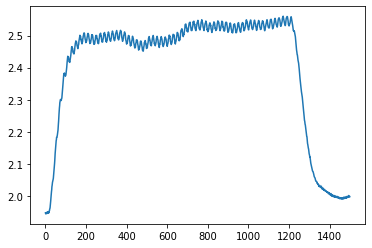

In [20]:
plt.plot(np.array(all_trial_flows).mean(axis=1)[0, 5000:6500])

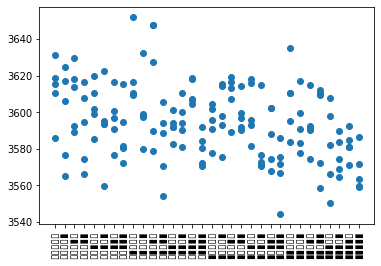

In [20]:
cl_flow = np.array(all_trial_flows)[:, :, 5000:6500, 0].sum(axis=-1).flatten()[:, np.newaxis]
cl_PID = np.array(all_trials_PID)[:, :, 5070:6270, 0].sum(axis=-1).flatten()[:, np.newaxis]
plt.scatter(ys, cl_flow)
plt.xticks(range(32), labels=glyphs, rotation=90);

In [18]:
y_preds_flow, y_trues_flow = classify(cl_flow, ys)
y_preds_PID, y_trues_PID = classify(cl_PID, ys)

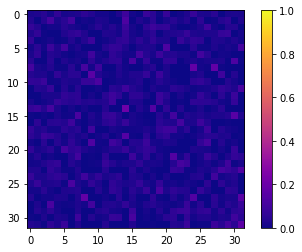

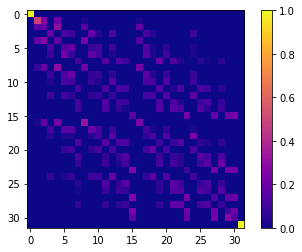

In [21]:
cm_flow = confusion_matrix(y_trues_flow, y_preds_flow, labels=range(32), normalize='true')
cm_PID = confusion_matrix(y_trues_PID, y_preds_PID, labels=range(32), normalize='true')
plt.imshow(cm_flow, vmax=1, cmap='plasma')
plt.colorbar()
plt.figure()
plt.imshow(cm_PID, cmap='plasma')
plt.colorbar()

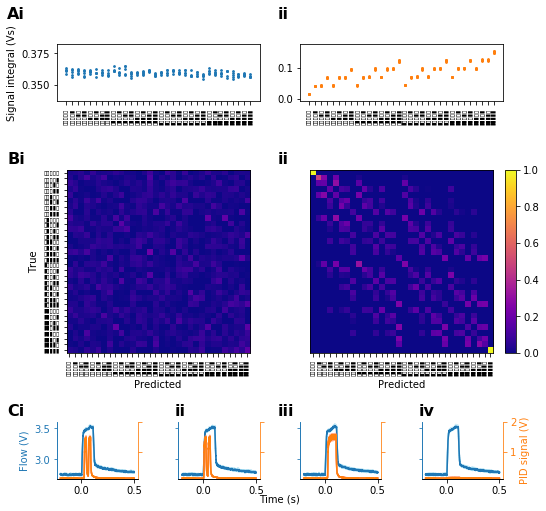

In [34]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, hspace=1.2, wspace=0.5)

cm_fs = 6

scatter_ax1 = fig.add_subplot(gs[0, :2])
scatter_ax2 = fig.add_subplot(gs[0, 2:])
scatter_ax1.scatter(ys, cl_flow/10000, color='C0', s=3)
scatter_ax2.scatter(ys, cl_PID/10000, color='C1', s=3)
scatter_ax1.set_ylabel('Signal integral (Vs)')
scatter_ax1.set_xticks(range(32))
scatter_ax1.set_xticklabels(glyphs, rotation=90, fontsize=cm_fs)
scatter_ax2.set_xticks(range(32))
scatter_ax2.set_xticklabels(glyphs, rotation=90, fontsize=cm_fs)



cm_ax1 = fig.add_subplot(gs[1:3, :2])
cm_ax2 = fig.add_subplot(gs[1:3, 2:])
im = cm_ax1.imshow(cm_flow, cmap='plasma', vmax=1)
cm_ax2.imshow(cm_PID, cmap='plasma', vmax=1)
cm_ax2_pos = cm_ax2.get_position()
cbar_ax = fig.add_axes([cm_ax2_pos.x0+0.02+cm_ax2_pos.width, cm_ax2_pos.y0,0.02, cm_ax2_pos.height])
cbar = plt.colorbar(cax=cbar_ax, mappable=im)
cm_ax1.set_xticks(range(32))
cm_ax1.set_xticklabels(glyphs, rotation=90, fontsize=cm_fs)
cm_ax2.set_xticks(range(32))
cm_ax2.set_xticklabels(glyphs, rotation=90, fontsize=cm_fs)
cm_ax1.set_yticks(range(32))
cm_ax1.set_yticklabels(glyphs, fontsize=cm_fs)
cm_ax2.set_yticks([])
cm_ax1.set_ylim(31.5, -0.5)
cm_ax2.set_ylim(31.5, -0.5)
cm_ax1.set_ylabel('True')
cm_ax1.set_xlabel('Predicted')
cm_ax2.set_xlabel('Predicted')

odour_ax1 = fig.add_subplot(gs[3, 0])
odour_ax2 = fig.add_subplot(gs[3, 1])
odour_ax3 = fig.add_subplot(gs[3, 2])
odour_ax4 = fig.add_subplot(gs[3, 3])
_, oax12 = plot_pid_and_flow(10, odour_ax1)
_, oax22 = plot_pid_and_flow(20, odour_ax2)
_, oax32 = plot_pid_and_flow(15, odour_ax3)
_, oax42 = plot_pid_and_flow(0, odour_ax4)
ylims1 = [i.get_ylim() for i in [odour_ax1, odour_ax2, odour_ax3, odour_ax4]]
ylims2 = [i.get_ylim() for i in [oax12, oax22, oax32, oax42]]
[i.set_ylim([np.min(ylims1), np.max(ylims1)]) for i in [odour_ax1, odour_ax2, odour_ax3, odour_ax4]]
[i.set_ylim([np.min(ylims2), np.max(ylims2)]) for i in [oax12, oax22, oax32, oax42]]
[i.set_yticklabels([]) for i in [odour_ax2, odour_ax3, odour_ax4, oax12, oax22, oax32]]
[i.tick_params(axis='y',colors='C0') for i in [odour_ax1, odour_ax2, odour_ax3, odour_ax4]]
[i.tick_params(axis='y',colors='C1') for i in [oax12, oax22, oax32, oax42]]
[i.spines['right'].set_color('C1') for i in [oax12, oax22, oax32, oax42]]
[i.spines['left'].set_color('C0') for i in [odour_ax1, odour_ax2, odour_ax3, odour_ax4]]
[i.spines['left'].set_color('C0') for i in [oax12, oax22, oax32, oax42]]
[i.spines['top'].set_visible(False) for i in [odour_ax1, odour_ax2, odour_ax3, odour_ax4, oax12, oax22, oax32, oax42]]
odour_ax1.set_ylabel('Flow (V)', color='C0')
oax42.set_ylabel('PID signal (V)', color='C1')
label_ax = fig.add_subplot(gs[3, :], frameon=False)
label_ax.set_xlabel('Time (s)', labelpad=15)
label_ax.set_xticks([])
label_ax.set_yticks([])

axes = [scatter_ax1, scatter_ax2, cm_ax1, cm_ax2, odour_ax1, odour_ax2, odour_ax3, odour_ax4]
labels = ['Ai', 'ii', 'Bi', 'ii', 'Ci', 'ii', 'iii', 'iv']
align_x = [[0, 2, 4], [1, 3, 6]]
align_y = [[0, 1], [2, 3], [4, 5, 6, 7]]
dy = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dy=dy)
plt.savefig('230909_Sup11.pdf', bbox_inches='tight')


In [167]:
dm1 =distance_matrix(cl_PID.reshape(32, 5).mean(axis=-1)[:, np.newaxis], cl_PID.reshape(32, 5).mean(axis=-1)[:, np.newaxis])
dm2 = distance_matrix(cl_flow.reshape(32, 5).mean(axis=-1)[:, np.newaxis], cl_flow.reshape(32, 5).mean(axis=-1)[:, np.newaxis])

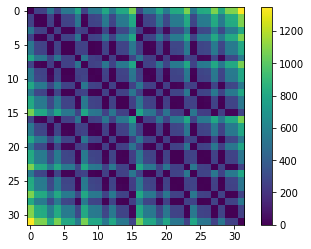

In [170]:
plt.imshow(dm1)
plt.colorbar()